# Introduction to Time Series Forecasting

PyData NYC - April 10, 2024

Jorn Mossel, PhD

# Example of Time Series Models

* Classical (statistical) Models
    * [ARIMA (AutoRegressive Integrated Moving Average)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) 
    * [Exponential Smoohting (Holt-Winters)](https://en.wikipedia.org/wiki/Exponential_smoothing)
    * ...
* Machine Learning Models
    * Turn traditional ML models into time series models (eg Linear Regression, Boosted Trees)
* Deep Learning
    * [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (RNN architecture)
    * [PatchTST](https://arxiv.org/pdf/2211.14730.pdf) (Transformer based) - 2022
    * [N-HiTS](https://arxiv.org/abs/2201.12886) (MLP architecture optimized for time series) - 2022
    * [TiDE](https://arxiv.org/abs/2304.08424) (encoder-decoder) - 2023
    * ...
* Foundation Models
    * [TimeGPT (by NIXTLA)](https://docs.nixtla.io/) - 2023
    * [Chronos (by Amazon)](https://www.amazon.science/code-and-datasets/chronos-learning-the-language-of-time-series) - March 2024

# Overview Python Packages for Time Series Forecasting

* [NIXTLA](https://nixtlaverse.nixtla.io/)
* [GluonTS](https://ts.gluon.ai/stable/)
* [Darts](https://unit8co.github.io/darts/index.html)
* [SKTIME](https://www.sktime.net/en/stable/)

In [1]:
%%capture
!pip install statsforecast
!pip install neuralforecast

In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1 #When running on Mac M1/M2

import matplotlib.pyplot as plt
import pandas as pd
import os

from statsforecast import StatsForecast
from statsforecast.arima import arima_string
from statsforecast.models import MSTL, AutoARIMA, AutoETS
from statsforecast.utils import AirPassengersDF, ConformalIntervals

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mape

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.models import NHITS, LSTM, PatchTST, NBEATS

os.environ['NIXTLA_ID_AS_COL'] = '1'

env: PYTORCH_ENABLE_MPS_FALLBACK=1 #When running on Mac M1/M2


/Users/jmossel/dev/time-series-tutorial/.venv/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/jmossel/dev/time-series-tutorial/.venv/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


# Example 1: Airline Passengers

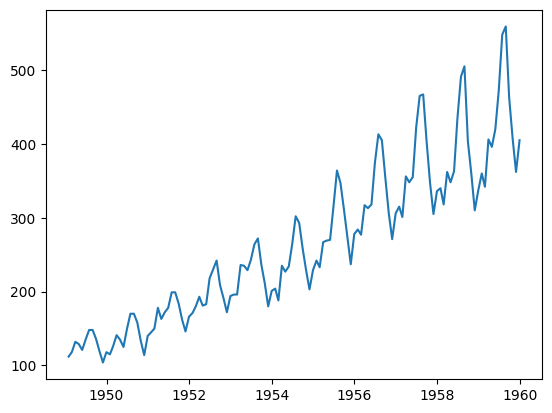

In [3]:
air_df = AirPassengersDF

air_train_df = air_df.iloc[:-12]
air_test_df = air_df.iloc[-12:]

plt.plot(air_train_df['ds'],air_train_df['y']);

# Trend Seasonal Decompostion
Time series can be decomposed in the following:
* Trend: $T(t)$
* Seasonal: $S(t)$
* Residuals: $R(t)$

Two different models:
* $y(t) = T(t) + S(t) + R(t)$ (additive)
* $y(t) = T(t) \times S(t) \times R(t)$ (multiplicative)


In [4]:
sf_trend_seasonal = StatsForecast(
    models = [MSTL(season_length=[12])], 
    freq='M', #monthly frequency
)
sf_trend_seasonal.fit(air_train_df)

StatsForecast(models=[MSTL])

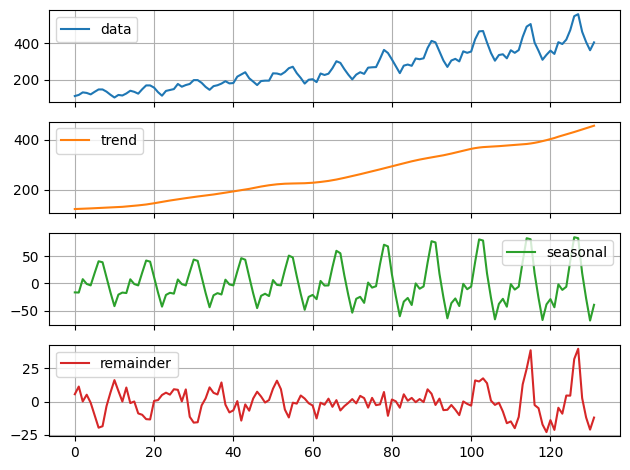

In [5]:
sf_trend_seasonal.fitted_[0, 0].model_.plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

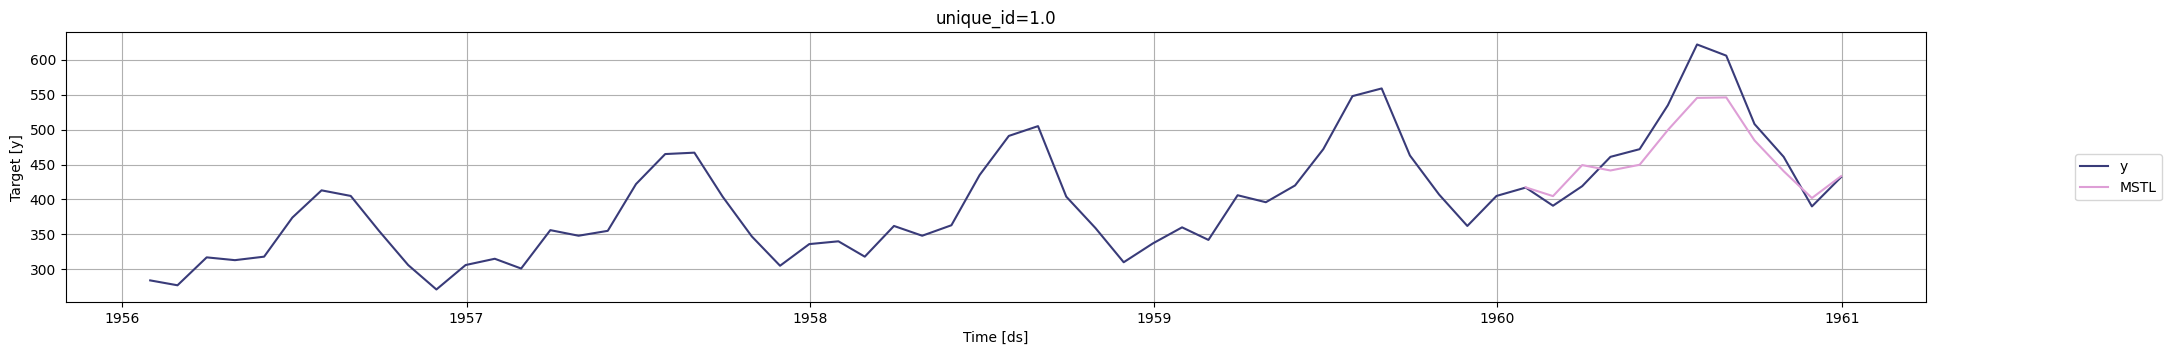

In [6]:
air_pred_df = sf_trend_seasonal.predict(h=12)
sf_trend_seasonal.plot(air_df, air_pred_df, max_insample_length=5*12)

# Classical Time Series Models (aka Statistical Models)

* ETS: Exponential Smoothing
* ARIMA: AutoRegressive Integrated Moving Average model - modeling (partial) autocorrelations

In [7]:
sf_classical = StatsForecast(
    models=[
        AutoARIMA(season_length = 12),
        AutoETS(season_length = 12, damped=True),
        # MSTL(season_length=12)        
        ],
    freq='M',
)

sf_classical.fit(air_train_df)

StatsForecast(models=[AutoARIMA,AutoETS])

In [8]:
arima_string(sf_classical.fitted_[0,0].model_)

'ARIMA(1,1,0)(0,1,0)[12]                   '

In [9]:
air_pred_classical_df = sf_classical.predict(h=12)

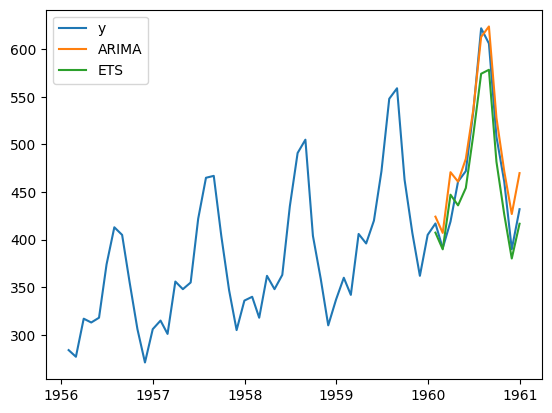

In [10]:
plt.plot(air_df['ds'].iloc[-60:],air_df['y'].iloc[-60:],label='y')
plt.plot(air_pred_classical_df ['ds'].iloc[-60:], air_pred_classical_df['AutoARIMA'].iloc[-60:],label='ARIMA')
plt.plot(air_pred_classical_df ['ds'].iloc[-60:], air_pred_classical_df['AutoETS'].iloc[-60:],label='ETS')
plt.legend()

## Evaluate Predictions ###

**MSE (Mean Squared Error):**
    $$\text{mean}((\hat{y}_t - y_t)^2)$$
Note: Not Scale dependent

**MAPE (Mean Absolute Percentage Error)**
$$\text{mean}(|\frac{\hat{y}_t-y_t}{y_t}|)$$
* "Easy" to interpret (because scale depedent)
* Doesn't behave well for values close to zero

In [11]:
air_eval_classical_df = air_pred_classical_df.copy()
air_eval_classical_df['y'] = air_test_df['y'].values
air_eval_classical_df['MSTL'] = air_pred_df['MSTL'].values
# air_eval_classical_df['Ensemble'] = 0.5 * air_eval_classical_df['AutoARIMA'] +0.5* air_eval_classical_df['AutoETS']

mape(air_eval_classical_df,['AutoARIMA','AutoETS','MSTL'])

,unique_id,AutoARIMA,AutoETS,MSTL
0,1.0,0.041876,0.044994,0.050862


### Neural Network Models

* LSTM (RNN - Recurrent Neural Network)
* PatchTST (transformer)
* NHiTS (MLP)

In [13]:
horizon = 12
max_steps = 200

sf_neural = NeuralForecast(models=[
    LSTM(h=horizon, encoder_hidden_size=128, decoder_hidden_size=128, max_steps=max_steps),
    PatchTST(h=horizon, input_size=100, n_heads=4, hidden_size=16, max_steps=max_steps),
    NHITS(h=horizon, input_size=24, max_steps=max_steps),
], freq='M')

sf_neural.fit(air_train_df)
air_neural_df = sf_neural.predict()

Seed set to 1
Seed set to 1
Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
air_neural_df['y'] = air_test_df['y'].values
mape(air_neural_df,['LSTM','PatchTST','NHITS'])

,unique_id,LSTM,PatchTST,NHITS
0,1.0,0.127713,0.038817,0.040174


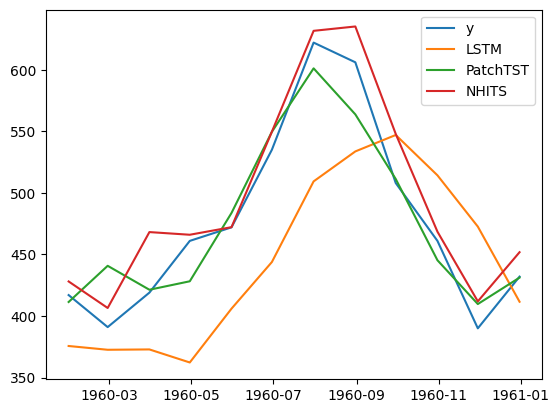

In [15]:
plt.plot(air_neural_df['ds'], air_neural_df['y'], label='y')
plt.plot(air_neural_df['ds'], air_neural_df['LSTM'], label='LSTM')
plt.plot(air_neural_df['ds'], air_neural_df['PatchTST'], label='PatchTST')
plt.plot(air_neural_df['ds'], air_neural_df['NHITS'], label='NHITS')
plt.legend()

# Probabilistic Forecasting 

In [16]:
intervals = ConformalIntervals(h=12, n_windows=4)

sf_prob = StatsForecast(
    models=[AutoARIMA(season_length = 12, prediction_intervals=intervals)],
    freq='M',
)
sf_prob.fit(air_train_df)

StatsForecast(models=[AutoARIMA])

In [17]:
levels = [75, 95] # confidence levels of the prediction intervals 

forecasts = sf_prob.forecast(h=12, level=levels)

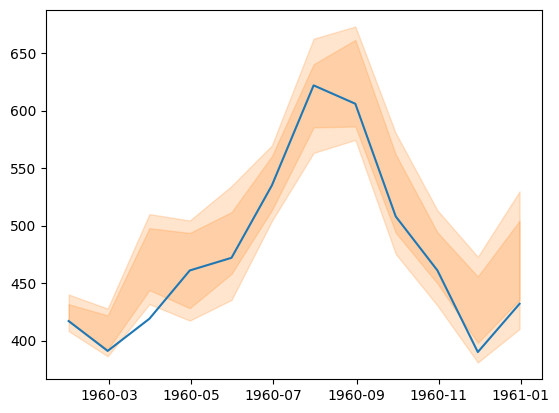

In [18]:
plt.fill_between(forecasts['ds'],forecasts['AutoARIMA-lo-95'],forecasts['AutoARIMA-hi-95'],alpha=0.20, color='tab:orange')
plt.fill_between(forecasts['ds'],forecasts['AutoARIMA-lo-75'],forecasts['AutoARIMA-hi-75'],alpha=0.20, color='tab:orange')
plt.plot(air_test_df['ds'], air_test_df['y'])

# Example 2: Energy Price Forecasting

In [19]:
epf_df = pd.read_csv("https://raw.githubusercontent.com/jjmossel/time-series-tutorial/master/electricty_demand.csv", parse_dates=['ds'])

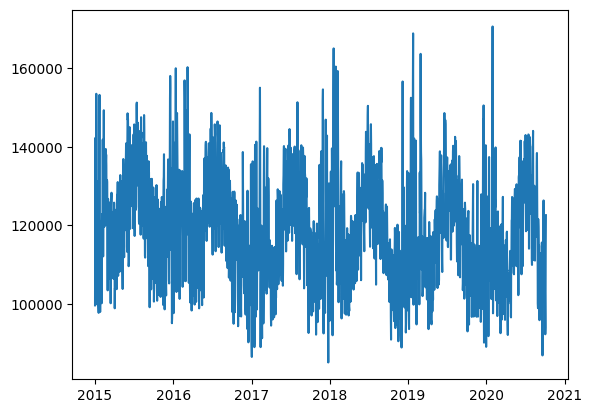

In [21]:
plt.plot(epf_df['ds'], epf_df['y'])

### Backtesting (Cross-Validation)

In [22]:
epf_df1 = epf_df.copy()
epf_df1 = epf_df1[['unique_id','ds','y']]

In [23]:
horizon = 1 # day-ahead daily forecast
epf_models_1 = [NHITS(h = horizon,

                input_size = 7*horizon,
                # futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                # stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                max_steps = 500,
                early_stop_patience_steps=2,
                val_check_steps = 100,
                scaler_type = 'robust')]


epf_nf1 = NeuralForecast(models=epf_models_1, freq='D')

Seed set to 1


In [24]:
epf_bt1 = epf_nf1.cross_validation(epf_df1, n_windows=7, step_size=horizon, val_size=horizon, refit=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

## Extend the Model with Covariates (Temperature variables)

Text(0, 0.5, 'demand')

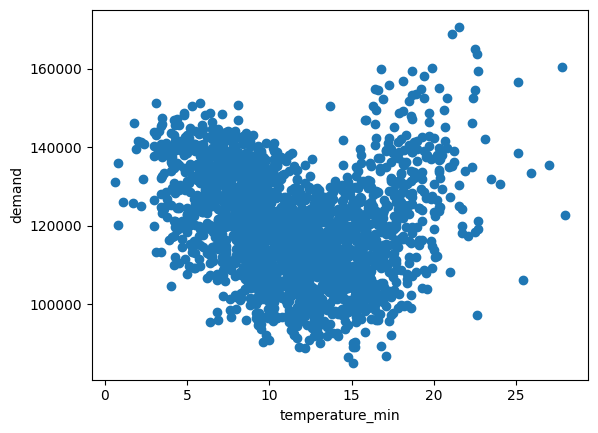

In [25]:
plt.scatter(epf_df['temperature_min'], epf_df['y'])
plt.xlabel('temperature_min')
plt.ylabel('demand')

In [26]:
epf_df2 = epf_df.copy()
epf_df2 = epf_df2[['unique_id','ds','y','temperature_min' ,'temperature_max','is_weekday']]

In [27]:
epf_models_2 = [NHITS(h = horizon,
                input_size = 7*horizon,
                futr_exog_list = ['temperature_min' ,'temperature_max','is_weekday'], # <- Future exogenous variables
                max_steps = 500,
                early_stop_patience_steps=2,
                val_check_steps = 100,
                scaler_type = 'robust')]

epf_nf2 = NeuralForecast(models=epf_models_2, freq='D')

Seed set to 1


In [28]:
epf_bt2  = epf_nf2.cross_validation(epf_df2, n_windows=7, step_size=horizon, val_size=horizon, refit=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
mape(epf_bt1 ,['NHITS']), mape(epf_bt2,['NHITS'])

(  unique_id     NHITS
 0  Victoria  0.074368,
   unique_id     NHITS
 0  Victoria  0.041593)